# # Coronavirus 2020 - effectiveness of measures taken - Spain

In [6]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
# Alternative plotting backend for interative data exploration
# %matplotlib notebook

from coronavirus import make_compare_plot_spain, fetch_data_spain, spain_get_region
# If you want to edit the source in the notebook, try "%load coronavirus.py" 
# and comment out the import statement above.

In [2]:
spanish_regions = ["Andalucía", "Aragón", "Asturias", "Cantabria", "Ceuta", "Castilla y León",
                   "Castilla-La Mancha", "Canarias", "Cataluña", "Extremadura", "Galicia",
                   "Islas Baleares", "Murcia", "Com. Madrid", "Melilla", "Navarra", "País Vasco",
                   "La Rioja", "Com. Valenciana"]

Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.3 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.3 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.3 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.3 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.5 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.3 seconds.
Please be patient - downloading da

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Completed downloading 1292 rows in 0.3 seconds.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


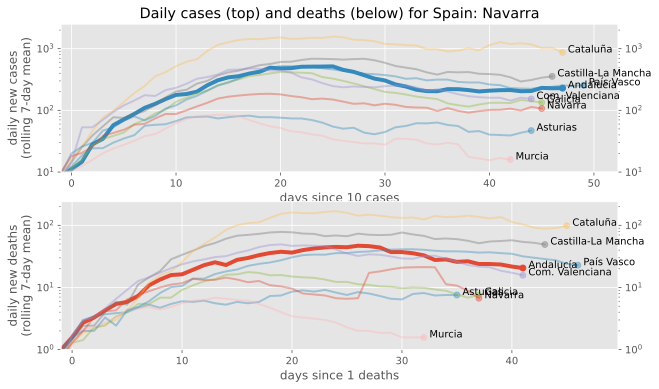

In [3]:
axes, c, d = make_compare_plot_spain("Navarra")

In [4]:
fetch_data_spain()

Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.4 seconds.


,Admin. region code,Cases,Positive PCR test,Positive Antibody test,Hospitalized,ICU,Deceases,Recovered,New cases
date,,,,,,,,,
2020-02-20,AN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-02-20,AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-02-20,AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-02-20,IB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-02-20,CN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
2020-04-26,ML,0.0,110.0,11.0,44.0,3.0,2.0,87.0,121
2020-04-26,MC,0.0,1474.0,297.0,627.0,106.0,128.0,990.0,1771
2020-04-26,NC,0.0,4733.0,753.0,1942.0,130.0,432.0,1918.0,5486


# Andalucía

In [7]:
cases_and, deaths_and = spain_get_region(region="Andalucía")

Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1292 rows in 0.4 seconds.


In [ ]:
cases_and.index[-1] + pd.DateOffset(days=5)

# La Rioja

In [ ]:
cases_rio, deaths_rio = spain_get_region(region="La Rioja")

# Comunidad de Madrid

In [ ]:
cases, deaths = spain_get_region(region="Com. Madrid")

# Cataluña

In [ ]:
cases, deaths = spain_get_region(region="Cataluña")

# País Vasco

In [ ]:
cases, deaths = spain_get_region(region="País Vasco")

# Canarias

In [ ]:
cases, deaths = spain_get_region(region="Canarias")